In [1]:
from Bio import Entrez
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import pandas as pd
import math
import random
Entrez.email = "lukas.becker@hhu.de"
overlap = [name for name in mcd.CSS4_COLORS]
overlap.remove("lightgrey")

In [2]:
rec_prot=pd.read_table("../data/synechococcus_cellulose_candidates/reciprocal_best_hits_protein_ids.txt")
fw_res=pd.read_table("../data/synechococcus_cellulose_candidates/blastp_fw_out.table",header=None)
fw_res.columns=["qseqid", "sseqid", "evalue", "bitscore", "qgi", "sgi", "sacc", "staxids", "sscinames", "scomnames",
                  "stitle"]

fw_res['qseqid'] = fw_res['qseqid'].map(lambda line: line.split('.')[0])
fw_res['sacc'] = fw_res['sacc'].map(lambda line: line.split('.')[0])
rec_prot = rec_prot.rename(columns={"forward_genome_id": "sacc"})
rec_prot = rec_prot.rename(columns={"backward_genome_id": "qseqid"})
result_data = rec_prot.merge(fw_res,how='inner', on=['sacc','qseqid'])
result_data = result_data.drop_duplicates('sacc', keep='first')

In [3]:
result_data.head()

,sacc,qseqid,sseqid,evalue,bitscore,qgi,sgi,staxids,sscinames,scomnames,stitle
0,WP_179075037,WP_011378340,WP_179075037.1_GCF_013393925.1_ASM1339392v1,2.110000e-43,171.0,0,0,2576903,Nostoc sp. C057,Nostoc sp. C057,glycosyltransferase [Nostoc sp. C057]
2,WP_096659806,WP_011378340,WP_096659806.1_GCF_002368095.1_ASM236809v1,2.170000e-93,313.0,0,0,1973488,Calothrix parasitica NIES-267,Calothrix parasitica NIES-267,UDP-forming cellulose synthase catalytic subun...
3,WP_096416426,WP_011378340,WP_096416426.1_GCF_002356215.1_ASM235621v1,1.050000e-09,65.9,0,0,1827144,Synechococcus sp. NIES-970,Synechococcus sp. NIES-970,glycosyltransferase family 2 protein [Synechoc...
4,WP_017291390,WP_011378340,WP_017291390.1_GCF_002368255.1_ASM236825v1,3.050000e-93,312.0,0,0,1973484,Leptolyngbya boryana NIES-2135,Leptolyngbya boryana NIES-2135,UDP-forming cellulose synthase catalytic subun...
7,WP_011432381,WP_011378340,WP_011432381.1_GCF_000013225.1_ASM1322v1,5.780000e-12,72.8,0,0,321332,Synechococcus sp. JA-2-3B'a(2-13),Synechococcus sp. JA-2-3B'a(2-13),cellulose synthase [Synechococcus sp. JA-2-3B'...


In [4]:
queries = open('../data/synechococcus_cellulose_candidates/CelluloseCandidates_Synechococcus7942.fasta','r')
lines = queries.readlines()
queries.close()

queries = []
for line in lines:
    if ">" in line:
        queries.append(line.split(" ")[0].split(".")[0].split(">")[1])
print(len(queries))

38


In [5]:
accid_taxids={}
for query in queries:
    accid_taxids[query] = result_data[result_data['qseqid'] == query]

In [6]:
accid_taxids[queries[0]].head()

,sacc,qseqid,sseqid,evalue,bitscore,qgi,sgi,staxids,sscinames,scomnames,stitle
0,WP_179075037,WP_011378340,WP_179075037.1_GCF_013393925.1_ASM1339392v1,2.110000e-43,171.0,0,0,2576903,Nostoc sp. C057,Nostoc sp. C057,glycosyltransferase [Nostoc sp. C057]
2,WP_096659806,WP_011378340,WP_096659806.1_GCF_002368095.1_ASM236809v1,2.170000e-93,313.0,0,0,1973488,Calothrix parasitica NIES-267,Calothrix parasitica NIES-267,UDP-forming cellulose synthase catalytic subun...
3,WP_096416426,WP_011378340,WP_096416426.1_GCF_002356215.1_ASM235621v1,1.050000e-09,65.9,0,0,1827144,Synechococcus sp. NIES-970,Synechococcus sp. NIES-970,glycosyltransferase family 2 protein [Synechoc...
4,WP_017291390,WP_011378340,WP_017291390.1_GCF_002368255.1_ASM236825v1,3.050000e-93,312.0,0,0,1973484,Leptolyngbya boryana NIES-2135,Leptolyngbya boryana NIES-2135,UDP-forming cellulose synthase catalytic subun...
7,WP_011432381,WP_011378340,WP_011432381.1_GCF_000013225.1_ASM1322v1,5.780000e-12,72.8,0,0,321332,Synechococcus sp. JA-2-3B'a(2-13),Synechococcus sp. JA-2-3B'a(2-13),cellulose synthase [Synechococcus sp. JA-2-3B'...


In [9]:
print(len(accid_taxids[queries[0]]['evalue']))

103


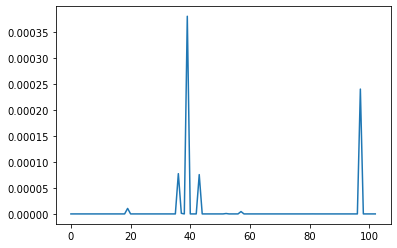

In [10]:
plt.plot(list(accid_taxids[queries[0]]['evalue']))

In [11]:
len(queries)

38

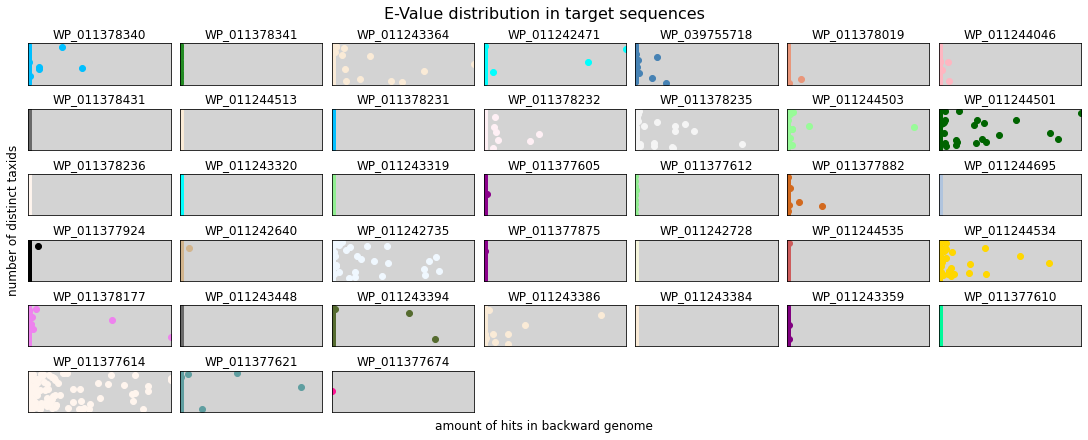

In [9]:
fig, axs = plt.subplots(math.floor(math.sqrt(len(queries))),math.ceil(math.sqrt(len(queries))), figsize=(15, 6), facecolor='w', edgecolor='k',constrained_layout=True)
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for ax in axs:
    ax.set_axis_off()

for i in range(len(queries)):
    axs[i].set_axis_on()
    axs[i].grid()
    axs[i].set_facecolor("lightgrey")
    cl = overlap[random.randint(0,len(overlap)-1)]
    axs[i].scatter(list(accid_taxids[queries[i]]['evalue']),range(len(accid_taxids[queries[i]]['evalue'])),color=cl)
    axs[i].set_title(str(queries[i]))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_xlim(0, 0.001)
    
#matplotlib version 3.4 support supylabel and supxlabel ...
fig.suptitle("E-Value distribution in target sequences", fontsize=16)
fig.supylabel("number of distinct taxids")
fig.supxlabel("amount of hits in backward genome")

plt.savefig("../data/synechococcus_cellulose_candidates/evalue_distribution.png",dpi=300)
#fig.tight_layout()

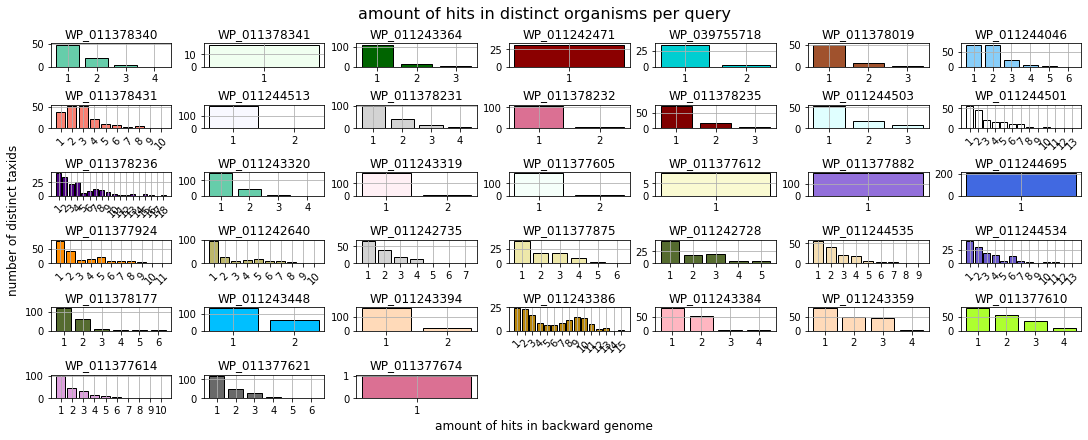

In [11]:
fig, axs = plt.subplots(math.floor(math.sqrt(len(queries))),math.ceil(math.sqrt(len(queries))), figsize=(15, 6), facecolor='w', edgecolor='k',constrained_layout=True)
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for ax in axs:
    ax.set_axis_off()

for i in range(len(accid_taxids.keys())):
    axs[i].set_axis_on()
    hit_distribution = {}
    for hit in accid_taxids[queries[i]]['staxids'].unique():
        val = accid_taxids[queries[i]][accid_taxids[queries[i]]['staxids'] == hit]['qseqid'].count()
        if val not in hit_distribution.keys():
            hit_distribution[val] = 1
        else:
            hit_distribution[val] += 1
    xvalues = []
    yvalues = []
    for key in sorted(hit_distribution.keys()):
        xvalues.append(key)
        yvalues.append(hit_distribution[key])
    axs[i].grid()    
    axs[i].bar(x=xvalues,height=yvalues,color=overlap[random.randint(0,len(overlap)-1)],width=0.8,edgecolor="black")
    axs[i].set_title(str(queries[i]))
    #axs[i].get_xaxis().set_visible(False)
    axs[i].set_xticks(range(1,max(list(hit_distribution.keys()))+1,1))
    
    if len(list(hit_distribution.keys())) >= 10:
        axs[i].tick_params('x', labelrotation=45)
    #axs[i].get_yaxis().set_visible(False)
    
fig.suptitle("amount of hits in distinct organisms per query", fontsize=16)
fig.supylabel("number of distinct taxids")
fig.supxlabel("amount of hits in backward genome")
plt.savefig("../data/synechococcus_cellulose_candidates/hits_per_organism.png",dpi=300)


In [ ]:
sorted(list(hit_distribution.keys()))

In [ ]:
len(list(hit_distribution.keys()))

In [ ]:
range(5,1)

In [ ]:
#single hits and multiple hits
hit_distribution = {}
for hit in accid_taxids[queries[13]]['staxids'].unique():
    val = accid_taxids[queries[13]][accid_taxids[queries[13]]['staxids'] == hit]['qseqid'].count()
    if val not in hit_distribution.keys():
        hit_distribution[val] = 1
    else:
        hit_distribution[val] += 1
        
xvalues = []
yvalues = []
for key in sorted(hit_distribution.keys()):
    xvalues.append(key)
    yvalues.append(hit_distribution[key])

In [ ]:
hit_distribution.values()

In [ ]:
xvalues

In [ ]:
plt.bar(x=xvalues,height=yvalues,color=overlap[random.randint(0,len(overlap)-1)])

In [ ]:
queries[18]

In [ ]:
queries.append("KKKKASASASA")

In [ ]:
handle = Entrez.efetch(db="protein",id=queries,retmode="xml")
record = Entrez.read(handle)
handle.close()

In [ ]:
len(record)

In [ ]:
#pfam_
for i in range(len(record)):
    record[i]['GBSeq_locus']
    print(record[i]['GBSeq_comment'])
    print("#############")


In [ ]:
import sys, os
from urllib.request import urlopen
import re
regex = re.compile("GO:[0-9]*")

##
## refseq2go.py
## By: Jake Warner
##

## This script takes a list of Refseq with IDs and outputs a tab deliminated file with the following fields:

# Refseq ID
# Uniprot ID
# Uniprot description
# GO IDs
# GO Biological process
# GO Molecular function
# GO Cellular Compartment

go_ids=[]
# isolate refseq ID
linecount=0
uprothits=0
uprotmissing=0
#loop the query IDs
for refseq_id in queries:
    linecount+=1
    
    page = urlopen('https://www.uniprot.org/uniprot/?query=database%3A%28type%3Arefseq+'+refseq_id+'%29&sort=score&columns=id,entry%20name,go-id,go,go(biological%20process),go(molecular%20function),go(cellular%20component)&format=tab').read()
    try:
        page = page.decode('utf-8').splitlines()[1]
        uprothits+=1
    except:
        uprotmissing+=1
    try:
        uprot_id =page.split('\t')[0]
    except:
        uprot_id ='No_Uniprot_ID'
    try:
        uprot_description=page.split('\t')[1]
    except:
        uprot_description='No_Uniprot_description'
    try:
        go_id=page.split('\t')[2]
    except:
        go_id='No_GO_Codes'
    try:
        go_bp=page.split('\t')[4]
    except:
        go_bp='No_GO_codes'
    try:
        go_mf=page.split('\t')[5]
    except:
        go_mf='No_GO_codes'
    try:
        go_cc=page.split('\t')[6]
    except:
        go_cc='No_GO_codes'
    print('%s\t%s\t%s\t%s\t%s\t%s\t%s\n'%(refseq_id,uprot_id,uprot_description,go_id,go_bp,go_mf,go_cc))
    string = go_id +" "+ go_bp +" "+go_mf+" "+go_cc
    res = re.findall(regex,string)
    for i in res:
        go_ids.append(i)
print("Read "+str(linecount)+" Refseq IDs")
print(str(uprothits) +" had a match in Uniprot")
print(str(uprotmissing) + " had no Uniprot match")

In [ ]:
go_file = open("go_ids.txt","w")

for go_id in go_ids:
    go_file.write("{}\n".format(go_id))

go_file.close()

In [ ]:
acc_file = open("acc_ids.txt","w")

for acc_id in queries:
    acc_file.write("{}\n".format(acc_id))
acc_file.close()